**Luca Manzi
856095**


# Analisi di SNPs per il gene ACTN3 e TP53


Il progetto consiste nel creare una pipeline in python per l'analisi di sequenze di diverse varianti di ACTN3, per studiare possibili Single Nucleotide Polymorthisms.

Gli **SNP**, acronimo che sta per "Single Nucleotide Polymorphism" (Polimorfismo a Singolo Nucleotide), sono variazioni genetiche che si verificano quando una singola lettera (nucleotide) del DNA è diversa in diverse persone o individui all'interno di una popolazione. 

l'**ACTN3** è un gene umano che codifica per una proteina chiamata alfa-actinina-3, che è coinvolta nella contrazione muscolare. Questa proteina è principalmente espressa nelle fibre muscolari rapide di tipo II, che sono responsabili della generazione di forza e della contrazione rapida durante attività ad alta intensità come sprint e sollevamento pesi.

Il gene **TP53**,"tumor protein p53", è un gene chiave coinvolto nella regolazione della crescita cellulare, nel controllo dell'integrità del DNA e nella prevenzione della formazione di tumori. La proteina p53 prodotta da questo gene agisce da soppressore tumorale, monitorando costantemente l'integrità del DNA all'interno delle cellule. Se si verificano danni al DNA, p53 può attivare processi che arrestano temporaneamente il ciclo cellulare per consentire la riparazione del DNA o, se i danni sono irreparabili, può indurre l'apoptosi (morte cellulare programmata) per prevenire la proliferazione di cellule danneggiate e potenzialmente cancerogene

Si sà che il numero di SNP in un gene può variare notevolmente a seconda di diversi fattori, tra cui la sua lunghezza, la sua funzione e la sua storia evolutiva. Non c'è un gene specifico che sia universalmente noto per avere più SNP rispetto agli altri. 

L'obiettivo è di identificare le posizioni dove avvengono più spesso polimorfismi, e le sostuzioni più frequenti trai nucleotidi.
Come riferimento per avere posizioni assolute, ho preso la sequenza di riferimento più recente.

Come sequenze da allineare ho avuto più opzioni, in principio ho usato il tool BLAST per ottenere tutte le reads con più similarità con la ACTN3, però come si vedrà, danno molti problemi in quanto se la similarità non è molto elevata si possono avere molti allineamenti ottimi, così da generare del rumore nel risultato.

Alla fine, ho deciso di prendere più varianti di ACTN3 e le ho ordinate per similarità tramite il sito della NCBI, usandole quindi per il confronto.
https://www.ncbi.nlm.nih.gov/nuccore/?term=ACTN3

# Imports

Uso per lo più utilities della libreria **biopython**:

- **SeqIO** per leggere e parsare il file **FASTA** contentente i dati,
- **PairwiseAligner** per gli allinementi di due sequenze

Inoltre:

- **Pandas**, **Matplotlib** per organizzare i dati e visualizzarli.
- **Seaborn** per le palette di di **Pyplot**

In [1]:
from Bio import SeqIO
from Bio.Align import PairwiseAligner
from Bio.Seq import Seq

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from datetime import datetime
import os

# Utilities

In questa sezione ci sono funzioni utilities:

- `align_seqs(seq1,seq2)`: allinea due sequenze usando il **PairwiseAligner** con i seguenti parametri:
    - allineamento globale,
    - penalità di gap opening e gap extension, 
    - mismatch penalizzato leggermente meno di un gap.
    

- `seqs_analisis(a,b, candidate_snips)`: prende due sequenze allineate e restituisce i possibili candidati **SNP** e le posizioni in cui vengono riscontrate. Le posizioni sono relative a questo preciso allineamento. Il dizionario **candidate_snips** viene inizializzato se non passato come argomento.

- `update_indices(seq, positions)`: converte gli indici relativi ritornati dalla align_seqs e trasformarli in assoluti, quindi data la sequenza di riferimento allineata, fa collassare gli indici delle sostituzioni sulla sequenza di riferimento senza gap, assoluta.

- `plot_dict(d)` : serve a plottare il **candidate_snips**, converte la tupla usata come chiave in stringa per essere usata come un label e plotta le occorrenze sul totale, ho implementato anche la versione a piechart, per avere più chiaro il risultato visivo quando è distribuito uniformemente

In [2]:
def align_seqs(seq1,seq2):
    aligner = PairwiseAligner()
    aligner.mode = 'global'
    aligner.match_score = 1
    aligner.mismatch_score = -0.5
    aligner.open_gap_score = -0.8
    aligner.extend_gap_score = -0.3
    aligner.target_end_gap_score = 0.0
    aligner.query_end_gap_score = 0.0
    alignments = aligner.align(seq1, seq2)
    # return best alignment, if too many len(aligment) will fail, catching it
    # 
    # From documentation of PairwiseAligner and PairiseAlignments 
    # "Note that pairwise aligners can return an astronomical number 
    # of alignments, even for relatively short sequences, 
    # if they align poorly to each other. 
    
    # We therefore recommend to first check the number of alignments, 
    # accessible as len(alignments), 
    # which can be calculated quickly 
    # even if the number of alignments is very large."
    
    try:
        l = len(alignments)
        print(f"alignment success with : {l} optimal alignments")
        return sorted(alignments)[0]
    except:
        print(f"too many optimal alignments, consider removing this seq, maybe it's not informative")
        return next(alignments)

In [3]:
def seqs_analisys(a,b, candidate_snips = {}):
    # sequence must be aligned
    assert(len(a) == len(b))
    
    relative_positions = []
    for i in range(len(a)):
        base1 = a[i]
        base2 = b[i]
        if  base1 != base2 and (base1 != '-' and base2 != '-'):
            if (base1,base2) in candidate_snips:
                candidate_snips[(base1,base2)] += 1
            elif (base2,base1) in candidate_snips:
                candidate_snips[(base2,base1)] += 1
            else:
                candidate_snips[(base1,base2)] = 1
            if (base1 != '-' and base2 != '-'):
                relative_positions.append(i)  
    return candidate_snips, relative_positions

In [4]:
def seqs_analisys_2(a,b ,candidate_snips = {}):
    # sequence must be aligned
    assert(len(a) == len(b))
    relative_positions = []
    ref = []
    var = []
    
    for i in range(len(a)):
        base1 = a[i]
        base2 = b[i]
        if  base1 != base2 and (base1 != '-' and base2 != '-'):
            ref.append(base1)
            var.append(base2)
            if (base1,base2) in candidate_snips:
                candidate_snips[(base1,base2)] += 1
            elif (base2,base1) in candidate_snips:
                candidate_snips[(base2,base1)] += 1
            else:
                candidate_snips[(base1,base2)] = 1
            if (base1 != '-' and base2 != '-'):
                relative_positions.append(i)
        abs_positions = update_indices(a ,relative_positions)
        
        an_df = pd.DataFrame({
                'Position': abs_positions,
                'Reference_Nucleotide': ref,
                'Variant_Nucleotide': var}
            )
    return candidate_snips, abs_positions, an_df

In [5]:
# positions must refer to the reference sequence,
# I make it colapse on '-', so all sequence aligments are referring to the same indices
def update_indices(seq, positions):
    starting_pos = 0
    for i, base in enumerate(seq):
        while starting_pos < len(positions) and positions[starting_pos] <= i:
            starting_pos += 1
        if base == '-':
            for j in range(starting_pos, len(positions)):
                positions[j] -= 1
    return positions

In [6]:
def plot_dict(d):
    sns.set_palette(sns.color_palette("Set2")[2:])
    keys = [', '.join(key) for key in d.keys()]
    values = list(d.values())
    total = sum(values)
    relative_values = [(x/total)*100 for x in values]
    plt.bar(keys, relative_values)
    plt.xlabel("Bases exchanged")
    plt.ylabel("Percentage of occurrences")
    plt.title("SNPs")
    # plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [7]:
def plot_dict_as_donut(d):
    sns.set_palette("Set2")
    keys = [', '.join(key) for key in d.keys()]
    values = list(d.values())
    total = sum(values)
    relative_values = [(x / total) * 100 for x in values]
    fig, ax = plt.subplots()
    pie = ax.pie(relative_values, 
                 labels=keys, 
                 autopct='%1.1f%%', 
                 startangle=140, 
                 pctdistance=0.85)
    center_circle = plt.Circle((0,0), 0.60, fc='white')
    fig.gca().add_artist(center_circle)
    plt.title("SNPs")
    ax.axis('equal')
    plt.tight_layout()
    plt.show()

# Preprocessing

1) Apro il file con le sequenze più simili, ho impostato fino a similarità 89%, ottenendo 46 sequenze
2) Noto che dalla sequenza 13 in poi ho troppi allineamenti e rischio di prenderne uno che non sia meaningful: la prima parte del progetto è eseguita con le prime 13 sequenze, ed i risultati saranno confrontati con un'altra iterazione contentente tutte e 46 le sequenze

In [8]:
seq_file = "seqdump.fasta"
# Load the FASTA files containing aligned DNA sequences
records = list(SeqIO.parse(seq_file, "fasta"))
print("aligned seqs #", len(records))

aligned seqs # 46


In [9]:
# First sequence in the file is the reference sequence
reference_seq = records[0].seq
seqs_to_align = [record.seq for record in records[1:]]

In [10]:
# I can see that:
align_seqs(reference_seq, seqs_to_align[11]) ## -> ok
align_seqs(reference_seq, seqs_to_align[12]) ## -> not ok
align_seqs(reference_seq, seqs_to_align[13]) ## -> not ok

alignment success with : 1 optimal alignments
too many optimal alignments, consider removing this seq, maybe it's not informative
too many optimal alignments, consider removing this seq, maybe it's not informative


<Alignment object (2 rows x 3045 columns) at 0x7f2c5e513e80>

## Insigth: SNP in a subseq

Mi aspetto di contare questa tipologia di eventi, nella sottosequenza sottostante, ad esempio, l'allinemento ottimale fa corrispondere 1 a 1 quasi ogni nucleotide, tranne per quel **T-C**.
Questa è la chiave della mia investigazione.

In [11]:
x = align_seqs(reference_seq, seqs_to_align[0])
print(x[:,1800:1850])

alignment success with : 1 optimal alignments
target         1800 CAAGGCAACACTGCCCGAGGCTGACTGAGAGCGAGGTGCCATCATGGGCA 1850
                  0 |||||||||||||||||||||||||.||||||||||||||||||||||||   50
query          1738 CAAGGCAACACTGCCCGAGGCTGACCGAGAGCGAGGTGCCATCATGGGCA 1788



# Putting all together

Adesso si può procedere con l'analisi di tutte le varianti,
mantengo in memoria un dizionario 
- `candidate_snips`, dove memorizzerò tutte le variazioni da che base a che base (l'ordine non sarà influente in questa analisi)
- `candidate_positions`, dove memorizzerò le posizioni in cui le ho riscontrate, rispetto alla sequenza di riferimento

In [12]:
candidate_snips = {}
candidate_positions = []

for seq in seqs_to_align[:12]:
    alignment = align_seqs(reference_seq , seq)
    candidate_snips, pos = seqs_analisys(alignment[0],
                                         alignment[1], 
                                         candidate_snips)
    pos = update_indices(alignment[0], pos)
    assert isinstance(pos, list), "pos is not a list"
    candidate_positions += pos

alignment success with : 1 optimal alignments
alignment success with : 1 optimal alignments
alignment success with : 1 optimal alignments
alignment success with : 1 optimal alignments
alignment success with : 1 optimal alignments
alignment success with : 1 optimal alignments
alignment success with : 1 optimal alignments
alignment success with : 1 optimal alignments
alignment success with : 1 optimal alignments
alignment success with : 1 optimal alignments
alignment success with : 1 optimal alignments
alignment success with : 1 optimal alignments


# Risultati

Posso quindi creare i grafici dei risultati: il grafico che mostra quali sono stae le sostituzioni più frequenti e quello che indica quali posizioni sono state coinvolte maggiormente.
- Si vede chiaramente che sono molto più frequenti i cambiamenti tra **T** e **C** e quelli tra **G** ed **A**,
- Poi che sebbene la sequenza di riferimento abbia 2952 elementi e quindi lo stesso numero di posizioni in cui si possano verificare SNPs, risultano poche e quasi sempre le stesse, le posizioni dove si riscontrano dei cambiamenti, es: **1825, 2423** ecc.

Riporto brevemente una legenda sui colori dei grafici, per aver chiaro a cosa mi riferisco.

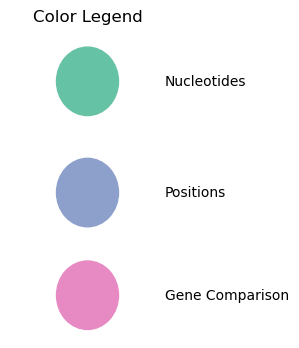

In [13]:
palette = sns.color_palette("Set2")

fig, ax = plt.subplots(figsize=(2, 4))  

circle = plt.Circle((1, 0.5), 0.4, color=palette[3]) 
ax.add_patch(circle)
circle_2 = plt.Circle((1, 1.7), 0.4, color=palette[2])  
ax.add_patch(circle_2)
circle_3 = plt.Circle((1, 3.0), 0.4, color=palette[0])  
ax.add_patch(circle_3)
ax.set_xlim(0, 2)
ax.set_ylim(0, 3.6) 
ax.set_xticks([])
ax.set_yticks([])

labels = ['Gene Comparison', 'Positions' ,'Nucleotides' ]
label_positions = [0.5, 1.7, 3.0]
for label, y in zip(labels, label_positions):
    ax.text(2, 
            y, 
            label, 
            verticalalignment='center', 
            fontsize=10, 
            ha='left')

ax.set_title("Color Legend")

# Remove spines and ticks
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='y', which='both', left=False, right=False)

#plt.tight_layout()
plt.show()


In [14]:
print("lunghezza seq riferiento = ", len(reference_seq))
print("candidate_snips: ", candidate_snips)

lunghezza seq riferiento =  2952
candidate_snips:  {('T', 'C'): 18, ('G', 'A'): 19, ('A', 'T'): 1, ('C', 'A'): 1}


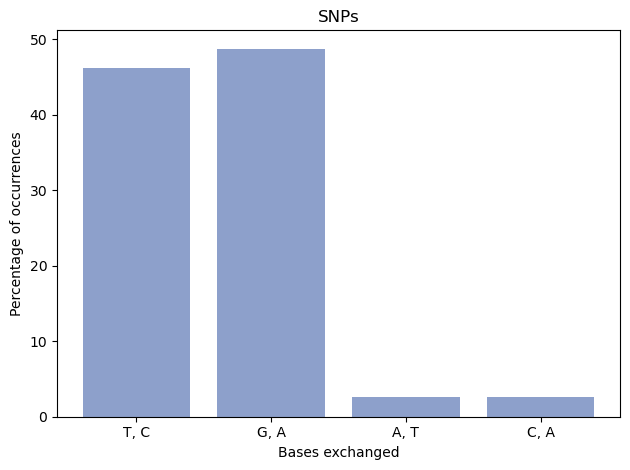

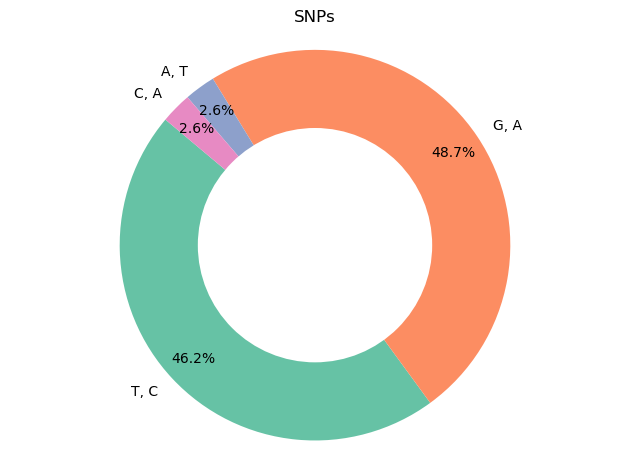

In [15]:
plot_dict(candidate_snips)
plot_dict_as_donut(candidate_snips)

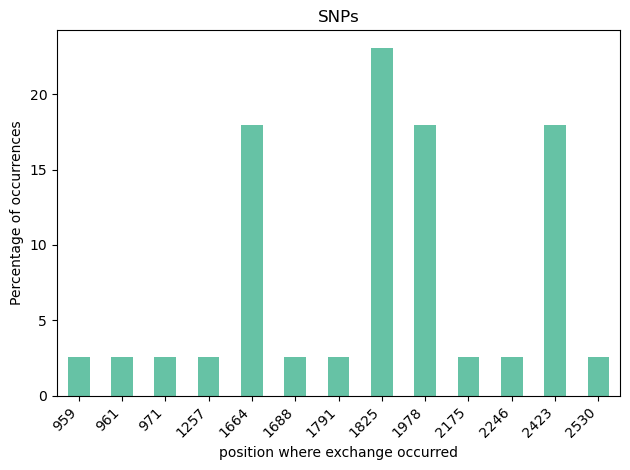

In [16]:
total_candidate_pos =  pd.Series(candidate_positions).value_counts()
total_candidate_pos =  (pd.Series(candidate_positions).value_counts()/
                        (sum(total_candidate_pos))*100).sort_index()
sns.set_palette(sns.color_palette("Set2"))
total_candidate_pos.plot(kind="bar")
plt.xlabel("position where exchange occurred")
plt.ylabel("Percentage of occurrences")
plt.title("SNPs")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [17]:
candidate_snips_2 = {}
candidate_positions_2 = []

for seq in seqs_to_align:
    alignment = align_seqs(reference_seq , seq)
    candidate_snips_2, pos = seqs_analisys(alignment[0],
                                           alignment[1], 
                                           candidate_snips_2)
    pos = update_indices(alignment[0], pos)
    assert isinstance(pos, list), "pos is not a list"
    candidate_positions_2 += pos

alignment success with : 1 optimal alignments
alignment success with : 1 optimal alignments
alignment success with : 1 optimal alignments
alignment success with : 1 optimal alignments
alignment success with : 1 optimal alignments
alignment success with : 1 optimal alignments
alignment success with : 1 optimal alignments
alignment success with : 1 optimal alignments
alignment success with : 1 optimal alignments
alignment success with : 1 optimal alignments
alignment success with : 1 optimal alignments
alignment success with : 1 optimal alignments
too many optimal alignments, consider removing this seq, maybe it's not informative
too many optimal alignments, consider removing this seq, maybe it's not informative
too many optimal alignments, consider removing this seq, maybe it's not informative
too many optimal alignments, consider removing this seq, maybe it's not informative
too many optimal alignments, consider removing this seq, maybe it's not informative
too many optimal alignments,

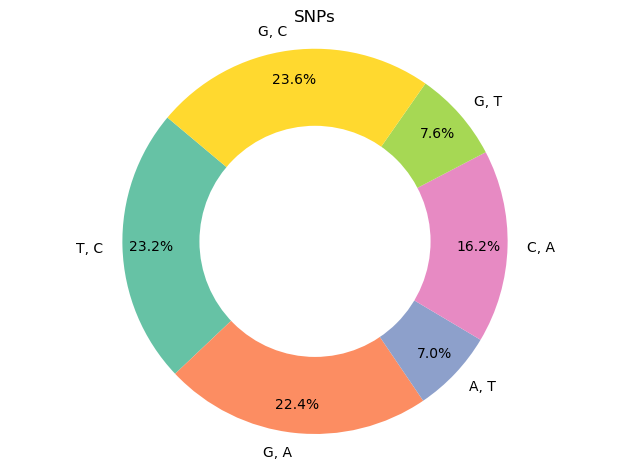

In [18]:
plot_dict_as_donut(candidate_snips_2)

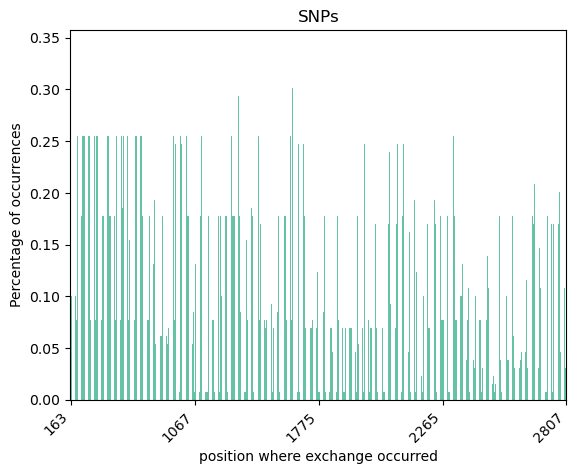

In [19]:
total_candidate_pos_2 =  pd.Series(candidate_positions_2).value_counts()
total_candidate_pos_2 =  (pd.Series(candidate_positions_2).value_counts()/
                        (sum(total_candidate_pos_2))*100).sort_index()
sns.set_palette(sns.color_palette("Set2"))
total_candidate_pos_2.plot(kind="bar")
plt.xlabel("position where exchange occurred")
plt.ylabel("Percentage of occurrences")
plt.title("SNPs")
plt.xticks(ticks=[0, 
                  (len(total_candidate_pos_2) // 4) ,
                  len(total_candidate_pos_2) // 2, 
                  (len(total_candidate_pos_2) // 4)*3 ,
                  len(total_candidate_pos_2)-1], 
           labels=[total_candidate_pos_2.index[0], 
                   total_candidate_pos_2.index[(len(total_candidate_pos_2) // 4)], 
                   total_candidate_pos_2.index[len(total_candidate_pos_2) // 2], 
                   total_candidate_pos_2.index[3*(len(total_candidate_pos_2) // 4)], 
                   total_candidate_pos_2.index[-1]], 
           rotation=45, ha="right")
#plt.tight_layout()
plt.show()


In [20]:
value_counts_df = pd.Series(candidate_positions_2).value_counts().reset_index()

# Rename columns for clarity
value_counts_df.columns = ['Position', 'Count']

In [21]:
value_counts_df[value_counts_df['Count'] >= 35]

,Position,Count
0,1436,44
1,1664,39
2,1409,38
3,1946,38
4,1417,35


#  Un gene più mutabile: TP53

In [22]:
seq_file_TP53 = "sequenceTP53.fasta"
# Load the FASTA files containing aligned DNA sequences
records = list(SeqIO.parse(seq_file_TP53, "fasta"))
print("aligned seqs #", len(records))
# First sequence in the file is the reference sequence
reference_seq = records[0].seq
seqs_to_align = [record.seq for record in records[1:]]
print("len =", len(reference_seq))

aligned seqs # 20
len = 123


In [23]:
candidate_snips_3 = {}
candidate_positions_3 = []

for seq in seqs_to_align:
    alignment = align_seqs(reference_seq , seq)
    candidate_snips_3, pos = seqs_analisys(alignment[0],
                                         alignment[1], 
                                         candidate_snips_3)
    pos = update_indices(alignment[0], pos)
    assert isinstance(pos, list), "pos is not a list"
    candidate_positions_3 += pos

alignment success with : 72 optimal alignments
alignment success with : 72 optimal alignments
alignment success with : 72 optimal alignments
alignment success with : 72 optimal alignments
alignment success with : 144 optimal alignments
alignment success with : 72 optimal alignments
alignment success with : 72 optimal alignments
alignment success with : 72 optimal alignments
alignment success with : 72 optimal alignments
alignment success with : 16 optimal alignments
alignment success with : 72 optimal alignments
alignment success with : 72 optimal alignments
alignment success with : 72 optimal alignments
alignment success with : 72 optimal alignments
alignment success with : 12 optimal alignments
alignment success with : 72 optimal alignments
alignment success with : 72 optimal alignments
alignment success with : 72 optimal alignments
alignment success with : 72 optimal alignments


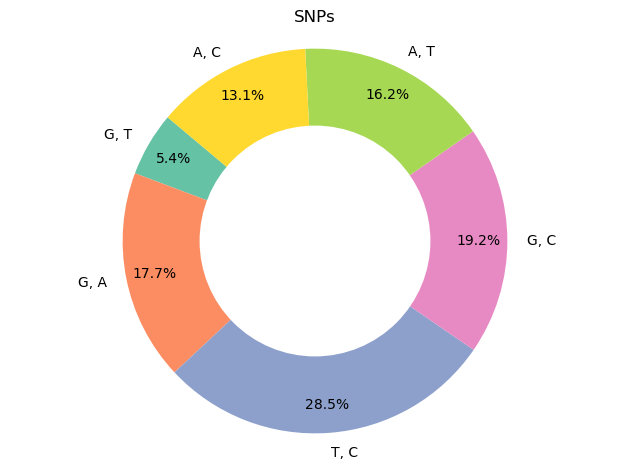

In [24]:
plot_dict_as_donut(candidate_snips_3)

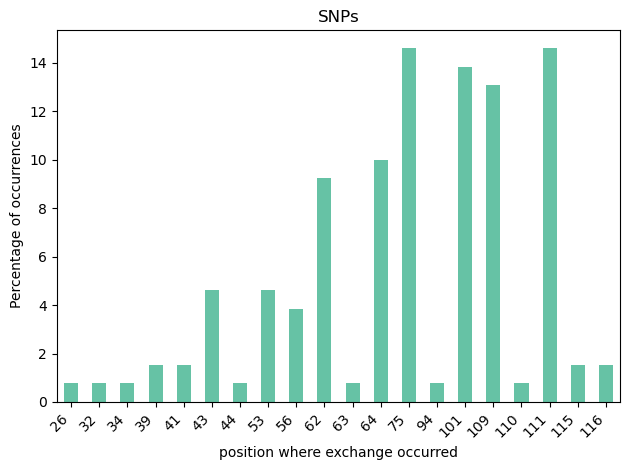

In [25]:
total_candidate_pos_3 =  pd.Series(candidate_positions_3).value_counts()
total_candidate_pos_3 =  (pd.Series(candidate_positions_3).value_counts()/
                        (sum(total_candidate_pos_3))*100).sort_index()
total_candidate_pos_3.plot(kind="bar")
sns.set_palette(sns.color_palette("Set2"))
plt.xlabel("position where exchange occurred")
plt.ylabel("Percentage of occurrences")
plt.title("SNPs")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Comparison

Si vede chiaramente la differenza di SNP rilevati nelle varianti dei due geni.
Senza contare che il gene **ACTN3** ha una lunghezza di 2952 nucleotidi e il **TP53** di soli 123, il che è ancora più a favore della teoria che stiamo cercando di dimostrare.

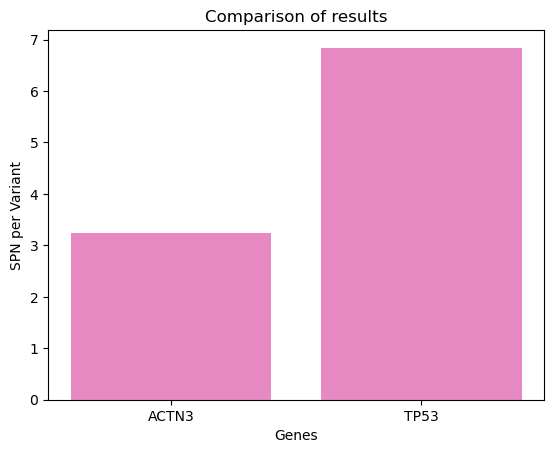

In [26]:
# Data for the bar plot
genes = ['ACTN3', 'TP53']
values = [(sum(candidate_snips.values())/12), 
          (sum(candidate_snips_3.values())/19)]
sns.set_palette(sns.color_palette("Set2")[3:])
plt.bar(genes, values)
plt.xlabel('Genes')
plt.ylabel('SPN per Variant')
plt.title('Comparison of results')
plt.show()

# Generating Output for SNP: SNV File

Per generare l'output ho modificato la funzione di analisi che ho scritto, in maniera che tenga traccia di ogni dettaglio dei possibili SNP, posizione, base nella sequenza di riferimento e quella nella variata.
Memorizzo tutto in un dataframe che poi userò filtrando le posizioni più significative che abbiamo trovato nella fase precedente.
Da qui procediamo con la creazione del file SNV (Variation)

In [27]:
seq_file = "seqdump.fasta"
# Load the FASTA files containing aligned DNA sequences
records = list(SeqIO.parse(seq_file, "fasta"))
# First sequence in the file is the reference sequence
reference_seq = records[0].seq
seqs_to_align = [record.seq for record in records[1:]]

In [28]:
# using se1s_anlaysis2, slower that keep track of which base geets Variated
candidate_snips_4 = {}
candidate_positions_4 = []
results_df = pd.DataFrame({
    'Position': [],
    'Reference_Nucleotide': [],
    'Variant_Nucleotide': []
})

for seq in seqs_to_align[:12]:
    alignment = align_seqs(reference_seq , seq)
    candidate_snips_4, pos, df = seqs_analisys_2(alignment[0], # seq 1
                                         alignment[1],  # seq 2
                                         candidate_snips_4)
    pos = update_indices(alignment[0], pos)
    assert isinstance(pos, list), "pos is not a list"
    candidate_positions_4 += pos
    results_df = pd.concat([results_df, df])

alignment success with : 1 optimal alignments
alignment success with : 1 optimal alignments
alignment success with : 1 optimal alignments
alignment success with : 1 optimal alignments
alignment success with : 1 optimal alignments
alignment success with : 1 optimal alignments
alignment success with : 1 optimal alignments
alignment success with : 1 optimal alignments
alignment success with : 1 optimal alignments
alignment success with : 1 optimal alignments
alignment success with : 1 optimal alignments
alignment success with : 1 optimal alignments


In [29]:
results_df['Position'] = results_df['Position'].astype(int)
results_df.head()

,Position,Reference_Nucleotide,Variant_Nucleotide
0,1825,T,C
0,1664,G,A
1,1825,T,C
2,1978,T,C
3,2423,A,G


In [30]:
# Filtering phase

value_counts_df_4 = pd.Series(candidate_positions_4).value_counts().reset_index()
value_counts_df_4.columns = ['Position', 'Count']

notable_pos_4 = value_counts_df_4[value_counts_df_4['Count'] >= 7]['Position']
filtered_results_df = results_df[results_df['Position'].isin(notable_pos_4)]

In [31]:
def write_to_file(smpl_name, orig_data, chromosome , offset, seq_aligned, filename):
    # Header
    header = [
    '##fileformat=VCFv4.3',
    '##fileDate=' + datetime.today().strftime('%Y%m%d'),
    '##source=Luca_Manzi_Bio_Inf_Project',
    '##INFO=<ID=DP,Number=1,Type=Integer,Description="Depth of variant">',
    '##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">',
    '#CHROM\tPOS\tID\tREF\tALT\tQUAL\tFILTER\tINFO\tFORMAT\tSAMPLE'
    ]
    sample_name = smpl_name

    vcf_lines = header.copy()  # init lines
    data = orig_data.copy() # copy DF it will be modified
    
    data['Position'] = data['Position'] + offset

    for index, row in data.iterrows():
        chrom = chromosome
        pos = row['Position'] ## already with offset
        ref = row['Reference_Nucleotide']
        alt = row['Variant_Nucleotide']
        dp = seq_aligned  # Seq aligned for this experiment
        genotype = '0/1'  # Change this if needed

        vcf_line = f'{chrom}\t{pos}\t.\t{ref}\t{alt}\t.\t.\tDP={dp}\tGT\t{genotype}'
        vcf_lines.append(vcf_line)

    # Save
    with open( filename , 'w') as vcf_file:
        vcf_file.write('\n'.join(vcf_lines))
    print("VCF file 'output.vcf' successfully written and saved.")

In [32]:
write_to_file('Sample1_ACTN3', 
              filtered_results_df, 
              'chr11', 
              66024242 ,  ## offset position of the start of ACTN3 in chr 11
              12, ## number of sequence i aligned to it
              'output.vcf')

VCF file 'output.vcf' successfully written and saved.


# Possibili sviluppi - Proteine

Un possibile sviluppo di questa pipeline potrebbe essere quella di usare un tool come BLAST (https://blast.ncbi.nlm.nih.gov/Blast.cgi) per ottenere dalle sequenze di partenza, le proteine che possono essere sintetizzate.
Gli SNP possono causare cambiamenti nella sequenza di amminoacidi di una proteina, quindi posso poi effettuare poi un confronto con le stesse per vedere se i cambiamenti riscontrati a livello di nucleotidi sono influenti oppure no, sulla sequenza delle proteine prodotte.
